# Data Scientist Professional Practical Exam

### Company Background
Nearly New Nautical is a website that allows users to advertise their used boats for sale. When users list their boat, they have to provide a range of information about their boat. Boats that get lots of views bring more traffic to the website, and more potential customers. 

To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views.


### Customer Question
The product manager wants to know the following:
- Can you predict the number of views a listing will receive based on the boat's features?



### Success Criteria
The product manager would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.


### Dataset
The data you will use for this analysis can be accessed here: `"data/boat_data.csv"`

In [80]:
# Import required packages
import numpy as np
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')


# 1 Data Validation

*Actions taken*
- price: extracted (local) price in column Price (int64) 
		 extracted the currency in column Curr (Object) and replaced Â£ with GBP for readability
		 created exchange rate column Rate (float64)
		 created price in Euro column Euro (float64)
         
- Boat Type: 126 unique Boat Types since combinations of types are listed.
			 Used first listing as Boat type. All types with less then 100 listings combined in 'other'.
             Resulting in 15 unique Boat Types (Category).

- Manufacturer: changed 1338 Manufacturer entries from 'null' to "Unknown" to preserve value

- Type: dropped 6 entries with missing values. 
		created fuel type column Fuel (category) for the 7 fuel types incl. unknown
        created condtion type column Condition (category) for the 4 conditions types incl. unknown

- Year Built: dropped >500 listings with invalid year 0. 
			  note: not happy to drop slightly more then 5% of data but given the remaining data, number of features, business case 				    I think dropping should be fine. 
              created age column for easier interpretation Age (float64) 

- Length: dropped 9 entries with missing values.
		  created Size category column based on length (industry std.) (category)

- Width: dropped 46 rows with missing width
		 dropped 1 invalid entry (width 0.01)
         note: check with business on minimum width (is width 0.5 valid?)
   
- Material: 1749 Material null entries to "Unknown" to preserve value
			Resulting in 7 material values (category)
			note: there is a reinforced concrete boat listed. Give input to marketing for some snappy adds

- Location: dropped 36 entries with missing values
			separated Countries in column 'Country' (object)
            Countries with <100 entries combined in World. Resulting in 11 countries (object)


- Validate Number of views last 7 days: target variable
										changed name to Views last7d for ease of use.
                                        no further cleaning required.
                                        
                         

Before cleaning 9888 entries over 10 columns
After cleaning 9241 entries over 14 columns


In [81]:
# info on data shows data is not ready for analysis
raw_df = pd.read_csv('data/boat_data.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 8550 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9852 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB


In [82]:
# impression of the data
raw_df.head(10)

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58
5,CHF 3650,Sport Boat,Linder power boats,new boat from stock,0,4.03,1.56,Aluminium,Switzerland Â» Lake Constance Â» Uttwil,132
6,CHF 3600,Catamaran,NaN,"Used boat,Unleaded",1999,6.20,2.38,Aluminium,Switzerland Â» Neuenburgersee Â» Yvonand,474
7,DKK 24800,Sport Boat,NaN,Used boat,0,3.00,NaN,NaN,Denmark Â» Svendborg,134
8,EUR 3333,Fishing Boat,Crescent power boats,new boat from stock,2019,3.64,1.37,NaN,Germany Â» Bayern Â» Boote+service Oberbayern,45
9,EUR 3300,Pontoon Boat,Whaly power boats,new boat from stock,2018,4.35,1.73,NaN,Italy Â» Dormelletto,180


In [83]:
# check numerical entries shows numbers to investigate such as year 0 and boat width 0.01.
raw_df.describe()

,Year Built,Length,Width,Number of views last 7 days
count,9888.000000,9879.000000,9832.000000,9888.000000
mean,1893.192860,11.570017,3.520124,149.160801
std,460.201582,6.002820,1.220534,151.819752
min,0.000000,1.040000,0.010000,13.000000
25%,1996.000000,7.470000,2.540000,70.000000
50%,2007.000000,10.280000,3.330000,108.000000
75%,2017.000000,13.930000,4.250000,172.000000
max,2021.000000,100.000000,25.160000,3263.000000


In [84]:
# Boat type, type, material could be transformed to categories
raw_df.nunique()


Price                          3182
Boat Type                       126
Manufacturer                    910
Type                             24
Year Built                      122
Length                         1612
Width                           575
Material                         11
Location                       2995
Number of views last 7 days     674
dtype: int64

In [85]:
# no duplicate entries
raw_df.duplicated().sum()

0

In [86]:
# multiple columns have null values
raw_df.isna().sum()


Price                             0
Boat Type                         0
Manufacturer                   1338
Type                              6
Year Built                        0
Length                            9
Width                            56
Material                       1749
Location                         36
Number of views last 7 days       0
dtype: int64

In [87]:
# Visualise relations in missing values
# missing length and width values have a strong relation (as to be expected)
#msno.heatmap(raw_df)

### Validate Price

In [88]:
# Price feature is type object and includes currency

raw_df['Price'] = raw_df['Price'].str.split() #split the price, results list
raw_df['Curr'] = raw_df['Price'].apply(lambda x: x[0]) #unpack list in new column
raw_df['Price_nw'] = raw_df['Price'].apply(lambda x: x[1]) #unpack list in new column
raw_df = raw_df.drop('Price', axis=1) #drop old price column
raw_df['Price_nw'] = raw_df['Price_nw'].astype('Int64') #change type to integer
raw_df.head()

,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days,Curr,Price_nw
0,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226,CHF,3337
1,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75,EUR,3490
2,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124,CHF,3770
3,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64,DKK,25900
4,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58,EUR,3399


In [89]:
#Inspect new Curr column
raw_df['Curr'] = raw_df['Curr'].str.replace('Â£', 'GBP')
raw_df['Curr'].value_counts(dropna=False)

EUR    8430
CHF     980
GBP     298
DKK     180
Name: Curr, dtype: int64

In [90]:
# Create exchange rate function and new column with all prices in Euro.
chf_euro = 1.02
gbp_euro = 1.16
dkk_euro = 0.13

def exchange(x):
    if (x == 'CHF'):
        rate = chf_euro
    elif (x == 'GBP'):
        rate = gbp_euro
    elif (x == 'DKK'): 
        rate = dkk_euro
    else:
        rate = 1
    return rate

raw_df['Rate'] = raw_df['Curr'].apply(lambda x: exchange(x))
raw_df['Euro'] = round(raw_df['Price_nw'] * raw_df['Rate'])
raw_df.head()

,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days,Curr,Price_nw,Rate,Euro
0,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226,CHF,3337,1.02,3404.0
1,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75,EUR,3490,1.00,3490.0
2,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124,CHF,3770,1.02,3845.0
3,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64,DKK,25900,0.13,3367.0
4,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58,EUR,3399,1.00,3399.0


In [91]:
# Validate Euro column, price range 3.300 - 31.000.000 seems valid although very wide range. Make sure to scale data before modeling.
raw_df['Price_nw'].describe()

count    9.888000e+03
mean     3.201373e+05
std      1.007482e+06
min      3.300000e+03
25%      4.400000e+04
50%      9.500000e+04
75%      2.550000e+05
max      3.100000e+07
Name: Price_nw, dtype: float64

### Validate Boat Type

In [92]:
# Validate different boat types --> note, could create categories
# no missing values
# some listings have multiple Boat types separated by ","
raw_df['Boat Type'].nunique()

126

In [93]:
# use first Boat Type entry as Boat Type
raw_df['Boat Type'] = raw_df['Boat Type'].str.split(",", expand=False)
raw_df['Boat Type'] = raw_df['Boat Type'].apply(lambda x: x[0])
raw_df['Boat Type'].info

<bound method Series.info of 0               Motor Yacht
1       Center console boat
2                Sport Boat
3                Sport Boat
4              Fishing Boat
               ...         
9883             Sport Boat
9884             Sport Boat
9885             Sport Boat
9886           Pontoon Boat
9887           Fishing Boat
Name: Boat Type, Length: 9888, dtype: object>

In [94]:
# All boats types with less then 100 listings in category 'Other' to improve feature value.
bt_counts = raw_df['Boat Type'].value_counts()
condition = bt_counts[bt_counts<100].index
mask = raw_df['Boat Type'].isin(condition)
raw_df['Boat Type'][mask]='Other'
raw_df['Boat Type'] = raw_df['Boat Type'].astype('category')
raw_df['Boat Type'].value_counts()

Motor Yacht            2736
Sport Boat             1417
Flybridge              1203
Trawler                 679
Cabin Boat              654
Pilothouse              614
Hardtop                 513
Other                   462
Center console boat     377
Bowrider                310
Deck Boat               285
Classic                 203
Fishing Boat            179
House Boat              148
Mega Yacht              108
Name: Boat Type, dtype: int64

### Validate Manufacturer

In [95]:
# manufacturer -> 1338 missing values as "null"
bool_series = pd.isnull(raw_df['Manufacturer'])
raw_df[bool_series].head()

,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days,Curr,Price_nw,Rate,Euro
6,Other,NaN,"Used boat,Unleaded",1999,6.20,2.38,Aluminium,Switzerland Â» Neuenburgersee Â» Yvonand,474,CHF,3600,1.02,3672.0
7,Sport Boat,NaN,Used boat,0,3.00,NaN,NaN,Denmark Â» Svendborg,134,DKK,24800,0.13,3224.0
17,Sport Boat,NaN,Used boat,1985,4.00,1.00,NaN,Denmark Â» Svendborg,124,DKK,30000,0.13,3900.0
19,Cabin Boat,NaN,"Used boat,Unleaded",2011,6.37,2.31,GRP,Germany Â» Bayern Â» Forchheim/Ofr.,330,EUR,4000,1.00,4000.0
24,Cabin Boat,NaN,Used boat,1985,6.53,2.47,NaN,"France Â» Marseille, France",383,EUR,3900,1.00,3900.0


In [96]:
#with so 1338 null values for manufacturer, makes sense to create Unknown variable
raw_df['Manufacturer'].fillna('Unknown', inplace=True)
raw_df.isna().sum()


Boat Type                         0
Manufacturer                      0
Type                              6
Year Built                        0
Length                            9
Width                            56
Material                       1749
Location                         36
Number of views last 7 days       0
Curr                              0
Price_nw                          0
Rate                              0
Euro                              0
dtype: int64

In [97]:
# With so many unique manufacturers, the predictive value is questionable
raw_df['Manufacturer'].nunique()

911

### Validate Type

In [98]:

raw_df['Type'].unique()

array(['new boat from stock', 'Used boat,Unleaded', 'Used boat',
       'Used boat,Electric', 'new boat from stock,Unleaded',
       'Used boat,Diesel', 'new boat on order', 'Unleaded',
       'new boat on order,Unleaded', 'new boat from stock,Gas', 'Diesel',
       'Display Model,Unleaded', 'Display Model', nan, 'Used boat,Gas',
       'new boat from stock,Diesel', 'new boat from stock,Electric',
       'new boat on order,Diesel', 'new boat from stock,Hybrid',
       'Display Model,Diesel', 'Used boat,Hybrid', 'Display Model,Gas',
       'Display Model,Electric', 'Electric', 'Used boat,Propane'],
      dtype=object)

In [99]:
raw_df['Type'].value_counts()

Used boat,Diesel                4140
Used boat,Unleaded              1686
Used boat                       1462
new boat from stock,Unleaded    1107
new boat from stock              665
new boat from stock,Diesel       291
new boat on order,Unleaded       150
Display Model,Unleaded            75
new boat on order                 61
new boat on order,Diesel          61
Diesel                            57
Used boat,Electric                27
Unleaded                          22
Display Model,Diesel              19
new boat from stock,Electric      18
Display Model                     18
Used boat,Gas                     10
Display Model,Electric             6
new boat from stock,Gas            2
new boat from stock,Hybrid         1
Used boat,Hybrid                   1
Display Model,Gas                  1
Electric                           1
Used boat,Propane                  1
Name: Type, dtype: int64

In [100]:
# Type has 6 missing values nan -> drop as they are <1% of data
raw_df.dropna(subset=['Type'], inplace=True)
raw_df.isna().sum()

Boat Type                         0
Manufacturer                      0
Type                              0
Year Built                        0
Length                            9
Width                            56
Material                       1744
Location                         36
Number of views last 7 days       0
Curr                              0
Price_nw                          0
Rate                              0
Euro                              0
dtype: int64

In [101]:
# Create Fuel type
# Create Condition 

def fuel(x):
    if ("diesel" in x.lower()):
        fuel = 'diesel'
    elif ("unleaded" in x.lower()):
        fuel = 'unleaded'
    elif ("electric" in x.lower()):
        fuel = 'electric'
    elif ("gas" in x.lower()):
        fuel = 'gas'
    elif ("hybrid" in x.lower()):
        fuel = 'hybrid'
    elif ("propane" in x.lower()):
        fuel = 'propane'
    else:
        fuel = 'unknown'
    return fuel


raw_df['Engine'] = raw_df['Type'].apply(lambda x: fuel(x)).astype('category')
raw_df['Engine'].value_counts()


diesel      4568
unleaded    3040
unknown     2206
electric      52
gas           13
hybrid         2
propane        1
Name: Engine, dtype: int64

In [102]:
#create condition column
def cond(x):
    if ("new" in x.lower()):
        cond = 'new'
    elif ("used" in x.lower()):
        cond = 'used'
    elif ("display" in x.lower()):
        cond = 'display'
    else:
        cond = 'unknown'
    return cond

raw_df['Condition'] = raw_df['Type'].apply(lambda x: cond(x)).astype('category')
raw_df['Condition'].value_counts()

used       7327
new        2356
display     119
unknown      80
Name: Condition, dtype: int64

### Validate Year Built

In [103]:
# validate Year Built, there are 0 entries
raw_df['Year Built'].unique()

array([2017, 2020,    0, 2019, 1999, 2018, 1987, 2004, 1997, 1985, 1981,
       2011, 1979, 1998, 1994, 1996, 1972, 1980, 1974, 1983, 1991, 1992,
       1961, 2015, 2000, 1993, 1968, 2007, 1990, 2010, 1975, 1986, 1941,
       1971, 2005, 1995, 1976, 2001, 2006, 2016, 1984, 1964, 1978, 1940,
       1988, 2003, 1977, 1973, 1970, 1913, 1965, 1950, 2014, 2002, 1963,
       2008, 1948, 1960, 1930, 2009, 1989, 1969, 1982, 1937, 2013, 2012,
       1954, 1959, 1909, 1926, 1910, 1962, 1938, 1936, 1967, 1903, 1933,
       1906, 1908, 2021, 1927, 1929, 1956, 1958, 1922, 1952, 1957, 1928,
       1905, 1951, 1911, 1966, 1915, 1934, 1939, 1953, 1924, 1931, 1920,
       1898, 1955, 1907, 1885, 1895, 1914, 1901, 1942, 1919, 1925, 1889,
       1946, 1904, 1923, 1917, 1949, 1947, 1912, 1945, 1897, 1902, 1900])

In [104]:
# about 5% of row has no year built -> delete these rows
raw_df[raw_df['Year Built']==0].shape

(550, 15)

In [105]:
raw_df['Year Built'] = raw_df['Year Built'].replace(0, np.nan)
raw_df.dropna(subset=['Year Built'], inplace=True)
raw_df.describe()

,Year Built,Length,Width,Number of views last 7 days,Price_nw,Rate,Euro
count,9332.000000,9323.000000,9277.000000,9332.000000,9.332000e+03,9332.000000,9.332000e+03
mean,2004.925847,11.750829,3.559262,150.235105,3.221062e+05,0.990411,3.041718e+05
std,16.337372,6.026418,1.218218,154.672573,9.783102e+05,0.122545,9.388178e+05
min,1885.000000,1.040000,0.010000,13.000000,3.300000e+03,0.130000,3.300000e+03
25%,1999.000000,7.570000,2.550000,70.000000,4.500000e+04,1.000000,4.490000e+04
50%,2008.000000,10.500000,3.400000,108.000000,9.850000e+04,1.000000,9.588450e+04
75%,2018.000000,14.000000,4.270000,172.000000,2.600000e+05,1.000000,2.500000e+05
max,2021.000000,100.000000,25.160000,3263.000000,3.100000e+07,1.160000,3.100000e+07


In [106]:
# Add age column
today = date.today().year
built = raw_df['Year Built']
raw_df['Age'] = today - built
raw_df['Age'].describe()

count    9332.000000
mean       17.074153
std        16.337372
min         1.000000
25%         4.000000
50%        14.000000
75%        23.000000
max       137.000000
Name: Age, dtype: float64

In [107]:
raw_df['Age'].value_counts()

2.0      1279
3.0       661
14.0      457
15.0      393
16.0      393
         ... 
108.0       1
127.0       1
137.0       1
91.0        1
122.0       1
Name: Age, Length: 120, dtype: int64

### Validate Length

In [108]:
raw_df['Length'].describe()

count    9323.000000
mean       11.750829
std         6.026418
min         1.040000
25%         7.570000
50%        10.500000
75%        14.000000
max       100.000000
Name: Length, dtype: float64

In [109]:
# with 9 missing length values it's safe to drop these rows.
raw_df.dropna(subset=['Length'], inplace=True)
raw_df.isna().sum()

Boat Type                         0
Manufacturer                      0
Type                              0
Year Built                        0
Length                            0
Width                            46
Material                       1653
Location                         36
Number of views last 7 days       0
Curr                              0
Price_nw                          0
Rate                              0
Euro                              0
Engine                            0
Condition                         0
Age                               0
dtype: int64

In [110]:
raw_df['Length'].describe()

count    9323.000000
mean       11.750829
std         6.026418
min         1.040000
25%         7.570000
50%        10.500000
75%        14.000000
max       100.000000
Name: Length, dtype: float64

### Validate Width

In [111]:
# boats with 0.01 width 
raw_df['Width'].describe()

count    9277.000000
mean        3.559262
std         1.218218
min         0.010000
25%         2.550000
50%         3.400000
75%         4.270000
max        25.160000
Name: Width, dtype: float64

In [112]:
raw_df['Width'].sort_values()

3107    0.01
9491    0.50
9660    0.50
9604    0.74
7216    0.86
        ... 
9700     NaN
9719     NaN
9797     NaN
9822     NaN
9861     NaN
Name: Width, Length: 9323, dtype: float64

In [113]:
# invalid listings
# 5 boats with a width >0.1m & < 1m left these in, check with business.
# 1 boat with a width <= 0.1m this can not be qualified as a boat, drop

raw_df[raw_df['Width']<1]

,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days,Curr,Price_nw,Rate,Euro,Engine,Condition,Age
2236,Motor Yacht,Sessa power boats,Used boat,2010.0,11.58,0.91,NaN,Malta Â» San ?iljan,73,EUR,175000,1.00,175000.0,unknown,used,12.0
3107,Motor Yacht,Unknown,"new boat from stock,Diesel",2020.0,12.80,0.01,PVC,France,34,EUR,812000,1.00,812000.0,diesel,new,2.0
7216,Pilothouse,Jeanneau power boats,new boat from stock,2020.0,2.41,0.86,PVC,"United Kingdom Â» Lincoln, Lincoln",67,GBP,63345,1.16,73480.0,unknown,new,2.0
9491,Motor Yacht,Unknown,"Display Model,Electric",2019.0,1.15,0.50,NaN,Germany Â» Nordrhein-Westfalen Â» Neukirchen-V...,86,EUR,15900,1.00,15900.0,electric,display,3.0
9604,Cabin Boat,Bayliner power boats,Used boat,1986.0,7.92,0.74,NaN,"United Kingdom Â» Lincoln, Lincoln",203,GBP,11950,1.16,13862.0,unknown,used,36.0
9660,Motor Yacht,Unknown,"Display Model,Electric",2019.0,1.15,0.50,NaN,Germany Â» Nordrhein-Westfalen Â» Neukirchen-V...,82,EUR,11900,1.00,11900.0,electric,display,3.0


In [114]:
#drop invalid entry and the 46 rows with missing width
raw_df['Width'].replace(0.01, np.nan)
raw_df.dropna(subset=['Width'], inplace=True)
raw_df.isna().sum()

Boat Type                         0
Manufacturer                      0
Type                              0
Year Built                        0
Length                            0
Width                             0
Material                       1627
Location                         36
Number of views last 7 days       0
Curr                              0
Price_nw                          0
Rate                              0
Euro                              0
Engine                            0
Condition                         0
Age                               0
dtype: int64

In [115]:
### Add Size category based boat length. Industry standard classes.
def size(x):
    if (x <= 5):
        size = "S"
    elif (x >5) & (x <= 8):
        size = "M"
    elif (x >8) & (x <= 12):
        size = "L"
    elif (x >12) & (x <= 20):
        size = "XL"
    else:
        size = "XXL"
    return size
    
raw_df['Size'] = raw_df['Length'].apply(lambda x: size(x)).astype('category')
raw_df.head()

,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days,Curr,Price_nw,Rate,Euro,Engine,Condition,Age,Size
0,Motor Yacht,Rigiflex power boats,new boat from stock,2017.0,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226,CHF,3337,1.02,3404.0,unknown,new,5.0,S
1,Center console boat,Terhi power boats,new boat from stock,2020.0,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75,EUR,3490,1.00,3490.0,unknown,new,2.0,S
3,Sport Boat,Pioner power boats,new boat from stock,2020.0,3.00,1.00,NaN,Denmark Â» Svendborg,64,DKK,25900,0.13,3367.0,unknown,new,2.0,S
4,Fishing Boat,Linder power boats,new boat from stock,2019.0,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58,EUR,3399,1.00,3399.0,unknown,new,3.0,S
6,Other,Unknown,"Used boat,Unleaded",1999.0,6.20,2.38,Aluminium,Switzerland Â» Neuenburgersee Â» Yvonand,474,CHF,3600,1.02,3672.0,unleaded,used,23.0,M


In [116]:
raw_df['Size'].value_counts()

L      3120
XL     2657
M      2479
XXL     754
S       267
Name: Size, dtype: int64

### Validate Material

In [117]:
raw_df['Material'].value_counts(dropna=False)

GRP                    5094
NaN                    1627
PVC                    1115
Steel                   909
Wood                    227
Aluminium               184
Plastic                  72
Carbon Fiber             29
Thermoplastic            13
Hypalon                   5
Reinforced concrete       1
Rubber                    1
Name: Material, dtype: int64

In [118]:
#too many NaN materials to drop or fill > create 'Unknown' variable. Recommend to business to ensure proper entries.
raw_df['Material'].fillna('Unknown', inplace=True)
raw_df['Material'].value_counts(dropna=False)

GRP                    5094
Unknown                1627
PVC                    1115
Steel                   909
Wood                    227
Aluminium               184
Plastic                  72
Carbon Fiber             29
Thermoplastic            13
Hypalon                   5
Reinforced concrete       1
Rubber                    1
Name: Material, dtype: int64

In [119]:
# concrete_boat ?!
raw_df[raw_df['Material']=='Reinforced concrete']


,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days,Curr,Price_nw,Rate,Euro,Engine,Condition,Age,Size
2341,House Boat,Unknown,"Used boat,Unleaded",2019.0,11.5,4.5,Reinforced concrete,Germany Â» Kiel- Laboe,169,EUR,199000,1.0,199000.0,unleaded,used,3.0,L


In [120]:
# Reduce Material options
m_counts = raw_df['Material'].value_counts()
m_condition = m_counts[m_counts<100].index
m_mask = raw_df['Material'].isin(m_condition)
raw_df['Material'][m_mask]='Other'
raw_df['Material'].value_counts()

GRP          5094
Unknown      1627
PVC          1115
Steel         909
Wood          227
Aluminium     184
Other         121
Name: Material, dtype: int64

### Validate Location

In [121]:
# Drop 36 null entries

raw_df = raw_df.dropna(subset=['Location'])
raw_df.isna().sum()

Boat Type                      0
Manufacturer                   0
Type                           0
Year Built                     0
Length                         0
Width                          0
Material                       0
Location                       0
Number of views last 7 days    0
Curr                           0
Price_nw                       0
Rate                           0
Euro                           0
Engine                         0
Condition                      0
Age                            0
Size                           0
dtype: int64

In [122]:
# create Country column and clean

raw_df['temp_loc'] = raw_df['Location'].str.split(" ", n=1)
raw_df['Country'] = raw_df['temp_loc'].apply(lambda x: x[0] )
raw_df = raw_df.drop('temp_loc', axis=1) #drop temp column
raw_df.head()

,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days,Curr,Price_nw,Rate,Euro,Engine,Condition,Age,Size,Country
0,Motor Yacht,Rigiflex power boats,new boat from stock,2017.0,4.00,1.90,Unknown,Switzerland Â» Lake Geneva Â» VÃ©senaz,226,CHF,3337,1.02,3404.0,unknown,new,5.0,S,Switzerland
1,Center console boat,Terhi power boats,new boat from stock,2020.0,4.00,1.50,Other,Germany Â» BÃ¶nningstedt,75,EUR,3490,1.00,3490.0,unknown,new,2.0,S,Germany
3,Sport Boat,Pioner power boats,new boat from stock,2020.0,3.00,1.00,Unknown,Denmark Â» Svendborg,64,DKK,25900,0.13,3367.0,unknown,new,2.0,S,Denmark
4,Fishing Boat,Linder power boats,new boat from stock,2019.0,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58,EUR,3399,1.00,3399.0,unknown,new,3.0,S,Germany
6,Other,Unknown,"Used boat,Unleaded",1999.0,6.20,2.38,Aluminium,Switzerland Â» Neuenburgersee Â» Yvonand,474,CHF,3600,1.02,3672.0,unleaded,used,23.0,M,Switzerland


In [123]:
# 229 entries as country "United" instead of proper: United Arab Emirates/United Kingdom/United States

temp_df = raw_df[raw_df['Country']=='United']
temp_df['temp_loc'] = temp_df['Location'].str.split(" ", n=2)
temp_df['Country'] = temp_df['temp_loc'].apply(lambda x: x[0] + " " + x[1])
temp_df = temp_df.drop('temp_loc', axis=1) #drop temp column

raw_df = raw_df[raw_df['Country'].str.contains('United') == False] # remove United countries from raw_df
dfs = [raw_df, temp_df] #concat both df's
nw_df = pd.concat(dfs)

In [124]:
# All Countries with less then 100 listings in category 'RoW' (rest of world) to improve feature value.

c_counts = nw_df['Country'].value_counts()
c_condition = c_counts[c_counts<100].index
c_mask = nw_df['Country'].isin(c_condition)

nw_df['Country'][c_mask]='World'
nw_df['Country'].value_counts()

Italy             1767
Germany           1579
France            1214
Netherlands       1017
Switzerland        981
Croatia            801
Spain              690
World              688
United Kingdom     207
Denmark            165
Portugal           132
Name: Country, dtype: int64

### Validate Number of views last 7 days


In [125]:
# validate number of views last 7 days - target variable
nw_df['Number of views last 7 days'].describe()

count    9241.000000
mean      150.446813
std       155.106784
min        13.000000
25%        70.000000
50%       108.000000
75%       172.000000
max      3263.000000
Name: Number of views last 7 days, dtype: float64

In [126]:
nw_df['Number of views last 7 days'].isna().sum()

0

In [127]:
# Rename columns for ease of use, drop redundant columns and save the clean dataframe as df
nw_df = nw_df.drop(labels=['Price_nw', 'Rate', 'Year Built', 'Type'], axis=1)
df = nw_df.rename(columns={
	"Number of views last 7 days": "Views7d",
    "Euro" : "Price Eur."})

df.columns

Index(['Boat Type', 'Manufacturer', 'Length', 'Width', 'Material', 'Location',
       'Views7d', 'Curr', 'Price Eur.', 'Engine', 'Condition', 'Age', 'Size',
       'Country'],
      dtype='object')

In [128]:
# Validated df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9241 entries, 0 to 9688
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Boat Type     9241 non-null   category
 1   Manufacturer  9241 non-null   object  
 2   Length        9241 non-null   float64 
 3   Width         9241 non-null   float64 
 4   Material      9241 non-null   object  
 5   Location      9241 non-null   object  
 6   Views7d       9241 non-null   int64   
 7   Curr          9241 non-null   object  
 8   Price Eur.    9241 non-null   Float64 
 9   Engine        9241 non-null   category
 10  Condition     9241 non-null   category
 11  Age           9241 non-null   float64 
 12  Size          9241 non-null   category
 13  Country       9241 non-null   object  
dtypes: Float64(1), category(4), float64(3), int64(1), object(5)
memory usage: 840.7+ KB


# Exploratory Data Analysis

### EDA steps
- distribution of target variable
- distribution of price variable
- heatmap to visualise correlations
- visualise target variable vs other features.
- visualise multivariable relations

## Target variable - Views last 7 days

We are predicting the number of views a listing will receive based on the boat's features so the views last 7 days is our target variable.

In [129]:
# show top(10)listings, we can see that most top listings are material GRP and boats in Switerserland. 
df.sort_values(by='Views7d', ascending=False).head(10)

,Boat Type,Manufacturer,Length,Width,Material,Location,Views7d,Curr,Price Eur.,Engine,Condition,Age,Size,Country
9580,Motor Yacht,Bayliner power boats,7.70,2.46,Other,Switzerland Â» Le Landeron (NE),3263,CHF,15198.0,unleaded,used,30.0,M,Switzerland
8723,Hardtop,Princess power boats,11.12,3.88,GRP,Switzerland Â» Neuenburgersee Â» Hauterive,2432,CHF,35700.0,diesel,used,43.0,L,Switzerland
6211,Bowrider,Windy power boats,12.35,3.48,GRP,Switzerland Â» Lago Maggiore Â» 6600 Locarno,2261,CHF,128418.0,diesel,used,20.0,XL,Switzerland
3700,Hardtop,Pershing power boats,20.30,5.20,GRP,Neustadt in Holstein (Ostsee),2154,EUR,949000.0,diesel,used,13.0,XXL,World
308,Sport Boat,Sea Ray power boats,6.14,2.34,Other,Switzerland Â» Murtensee Â» Avenches,2026,CHF,20298.0,unleaded,used,29.0,M,Switzerland
894,Cabin Boat,Viper power boats,6.65,2.30,GRP,Switzerland Â» Horn,1970,CHF,49470.0,unleaded,used,8.0,M,Switzerland
9878,Sport Boat,Tullio Abbate power boats,6.00,2.10,GRP,Switzerland Â» Lake of Zurich Â» Rafz,1917,CHF,5099.0,unleaded,used,42.0,M,Switzerland
8684,Sport Boat,Correct Craft power boats,6.40,2.31,GRP,Switzerland Â» Lago Maggiore Â» Ticino,1834,CHF,36720.0,unleaded,used,17.0,M,Switzerland
9843,Sport Boat,Baha power boats,6.80,2.38,GRP,Thun,1831,CHF,6630.0,unleaded,used,27.0,M,World
35,Cabin Boat,Draco power boats,6.20,2.45,GRP,Switzerland Â» Walensee Â» Walenstadt,1804,CHF,3876.0,unleaded,used,42.0,M,Switzerland


[Text(0.5, 1.0, 'Distribution of Views last 7 days(Log Scale)')]

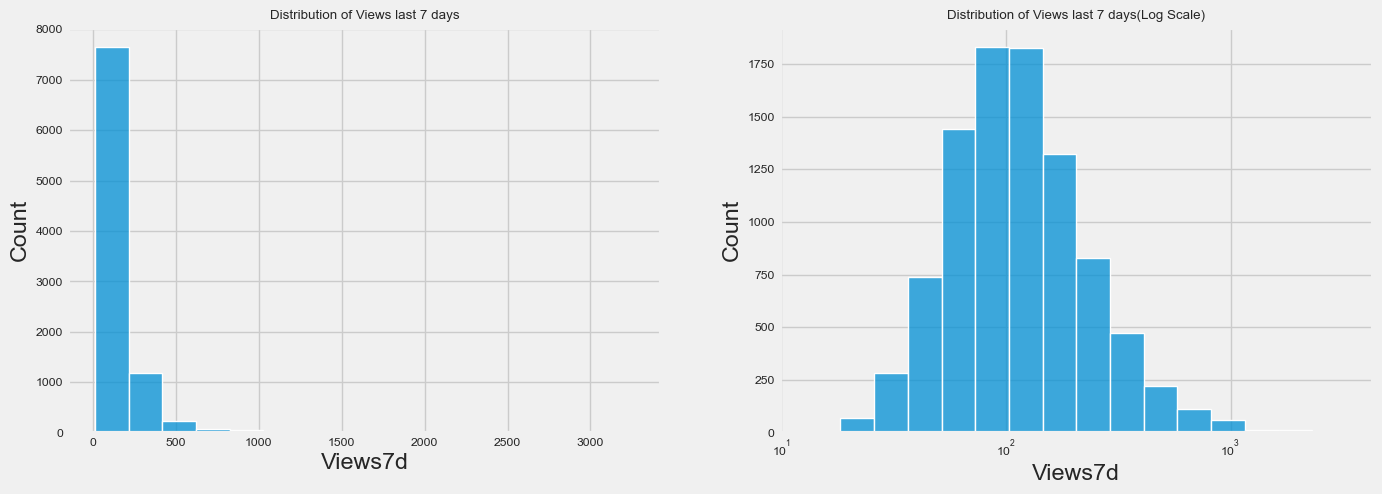

In [130]:
# Distribution of our target variable is approxiametely normally distributed on a log scale.
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.set(font_scale=0.8)
sns.histplot(df['Views7d'], ax=axes[0], bins=16).set(title='Distribution of Views last 7 days')
sns.histplot(df['Views7d'], ax=axes[1], bins=16, log_scale=True).set(title='Distribution of Views last 7 days(Log Scale)')

[Text(0.5, 1.0, 'Distribution of Views last 7 days')]

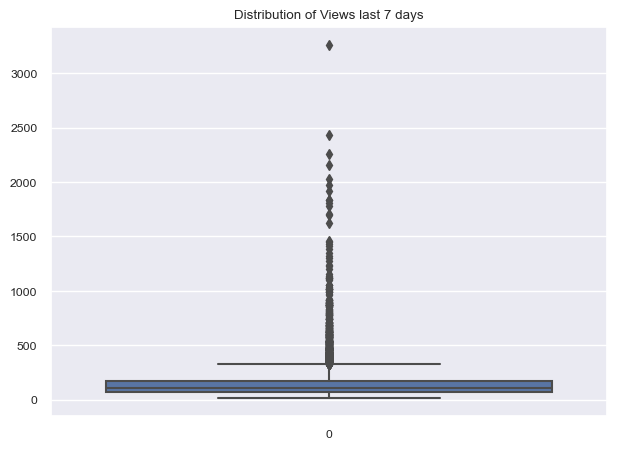

In [131]:
# Boxplot of the Views7 days, we see many outliers
fig, axes = plt.subplots()
sns.set(font_scale=0.8)
sns.boxplot(df['Views7d'], showfliers=True).set(title='Distribution of Views last 7 days')

[Text(0.5, 1.0, 'Distribution of Views last 7 days')]

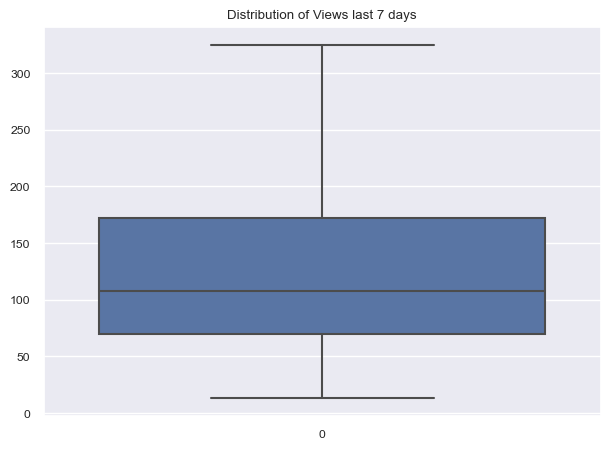

In [132]:
# Boxplot of Views7days without the outliers give better view of distribution
fig, axes = plt.subplots()
sns.set(font_scale=0.8)
sns.boxplot(df['Views7d'], showfliers=False).set(title='Distribution of Views last 7 days')


[Text(0.5, 1.0, 'The Distribution of Price (Log Scale)')]

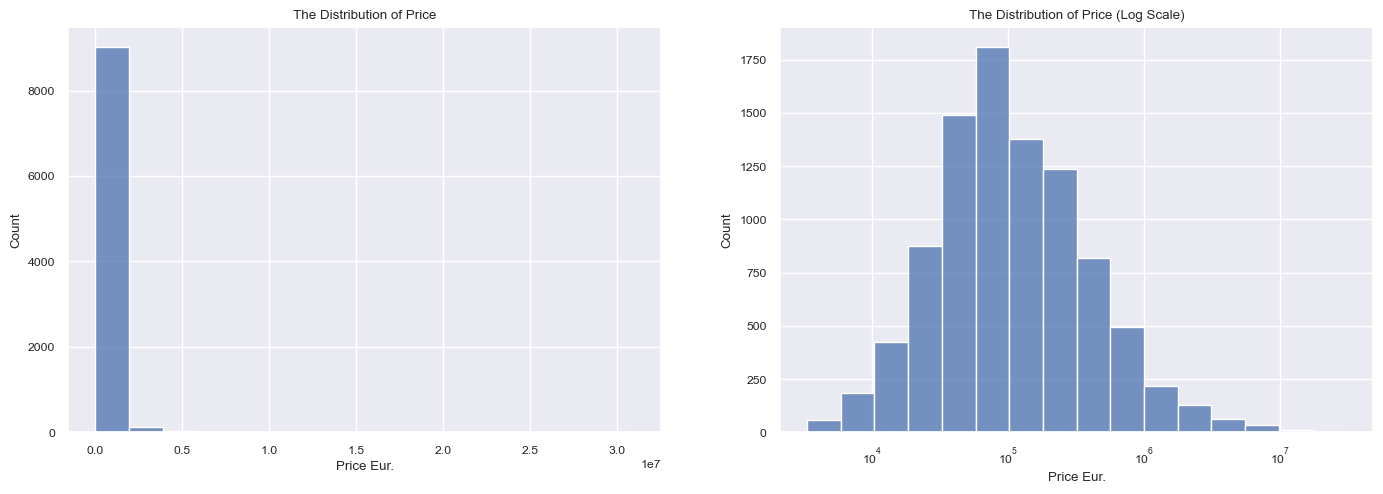

In [133]:
# checking the distribution of price is approxiametely normally distributed on log scale
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.set(font_scale=0.8)
sns.histplot(df['Price Eur.'], ax=axes[0], bins=16).set(title='The Distribution of Price' )
sns.histplot(df['Price Eur.'], ax=axes[1], bins=16, log_scale=True).set(title='The Distribution of Price (Log Scale)')

[Text(0.5, 1.0, 'The Distribution of Age')]

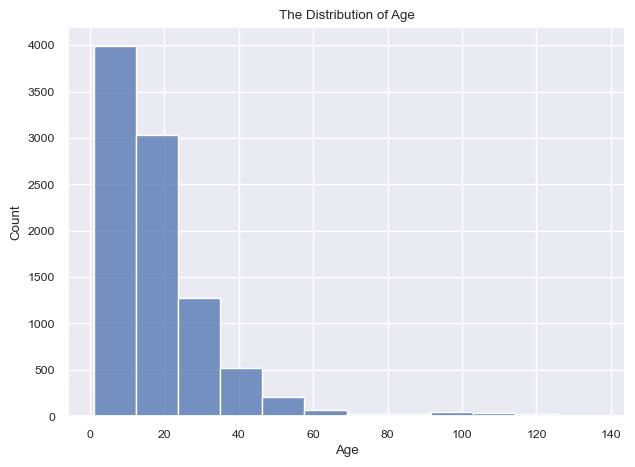

In [134]:
# checking the distribution of Age, the older the fewer listings
fig, axes = plt.subplots()
sns.set(font_scale=0.8)
sns.histplot(df['Age'], bins=12).set(title='The Distribution of Age' )

Text(0.5, 1.0, 'Correlation Heatmap')

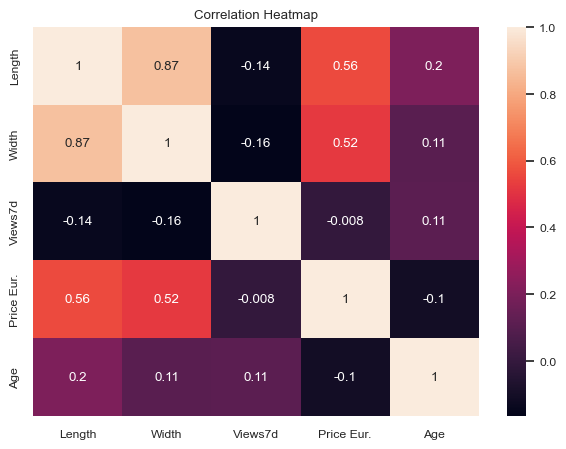

In [135]:
# We see the expected strong positive Length-Width correlation
# We see the expected moderate positive correlation between the price and Length/Width of a boat
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation Heatmap')

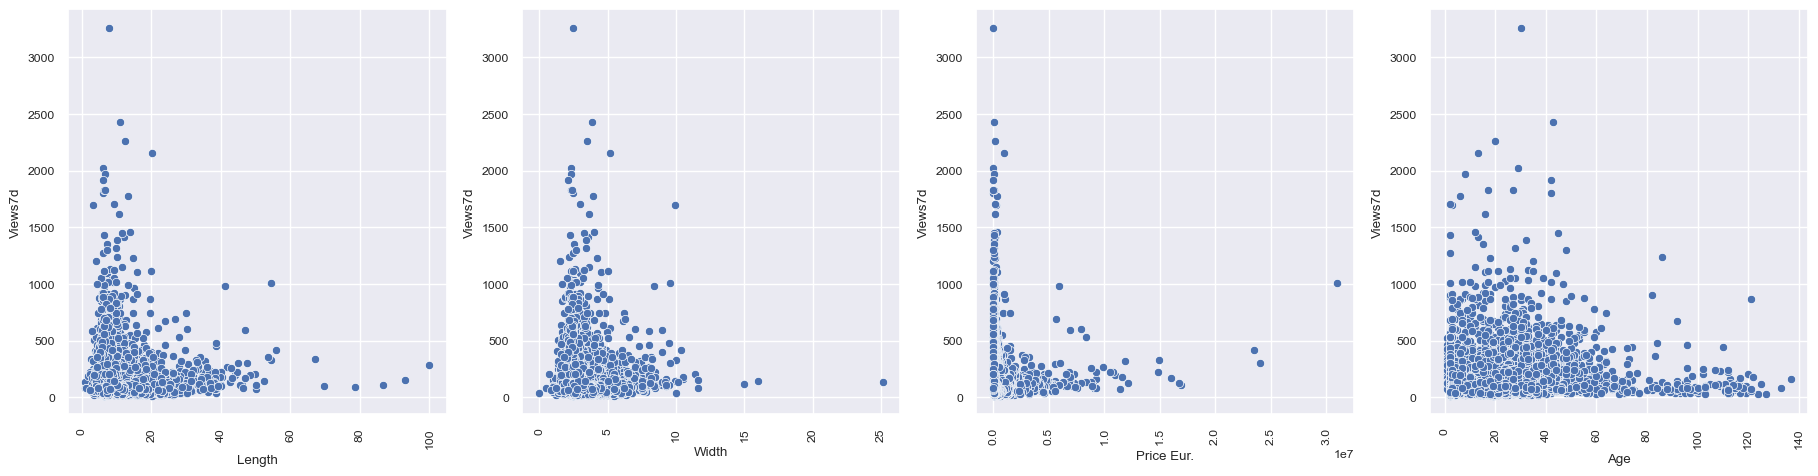

In [136]:
# Also in the scatterplots we can not see a clear linear trend between the target and numeric explanatory variables.
fig, axes = plt.subplots(1,4,figsize=(20,5))
sns.scatterplot(data=df, x='Length' , y='Views7d',ax=axes[0])
sns.scatterplot(data=df, x='Width' , y='Views7d',ax=axes[1])
sns.scatterplot(data=df, x='Price Eur.' , y='Views7d', ax=axes[2])
sns.scatterplot(data=df, x='Age' , y='Views7d',ax=axes[3])
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90);

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'S'),
  Text(1, 0, 'M'),
  Text(2, 0, 'L'),
  Text(3, 0, 'XL'),
  Text(4, 0, 'XXL')])

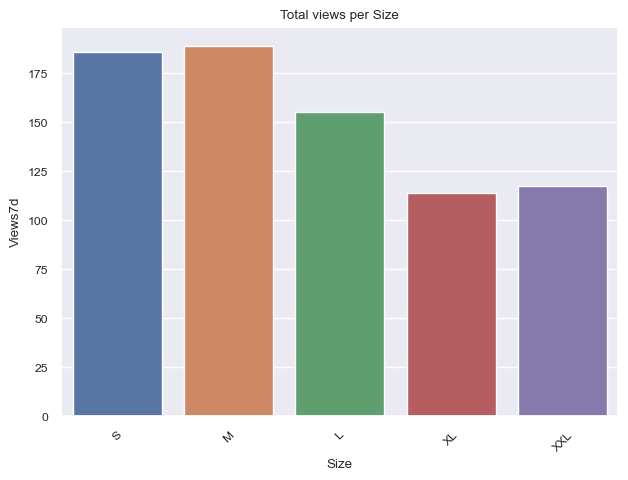

In [137]:
# Checking views vs size, smaller boats have more total views
fig, axes = plt.subplots()
sns.set(font_scale=0.8)
sns.barplot(data=df, x='Size', y='Views7d', order=['S','M','L','XL','XXL'],errorbar=None).set(title = 'Total views per Size')
plt.xticks(rotation=45)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Bowrider'),
  Text(1, 0, 'Cabin Boat'),
  Text(2, 0, 'Center console boat'),
  Text(3, 0, 'Classic'),
  Text(4, 0, 'Deck Boat'),
  Text(5, 0, 'Fishing Boat'),
  Text(6, 0, 'Flybridge'),
  Text(7, 0, 'Hardtop'),
  Text(8, 0, 'House Boat'),
  Text(9, 0, 'Mega Yacht'),
  Text(10, 0, 'Motor Yacht'),
  Text(11, 0, 'Other'),
  Text(12, 0, 'Pilothouse'),
  Text(13, 0, 'Sport Boat'),
  Text(14, 0, 'Trawler')])

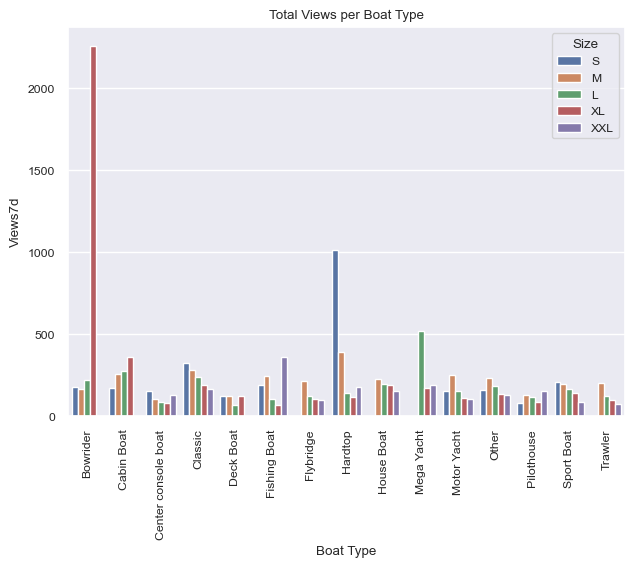

In [138]:
# Checking views per Boat Type and size shows that the XL Bowrider causes most views. 
# Also, the small Hardtop and large mega Yacht stand out.
fig, axes = plt.subplots()
sns.set(font_scale=0.8)
sns.barplot(data=df, x='Boat Type', y='Views7d',hue='Size', hue_order=['S','M','L','XL','XXL'], errorbar=None)
plt.title('Total Views per Boat Type')
plt.xticks(rotation=90)


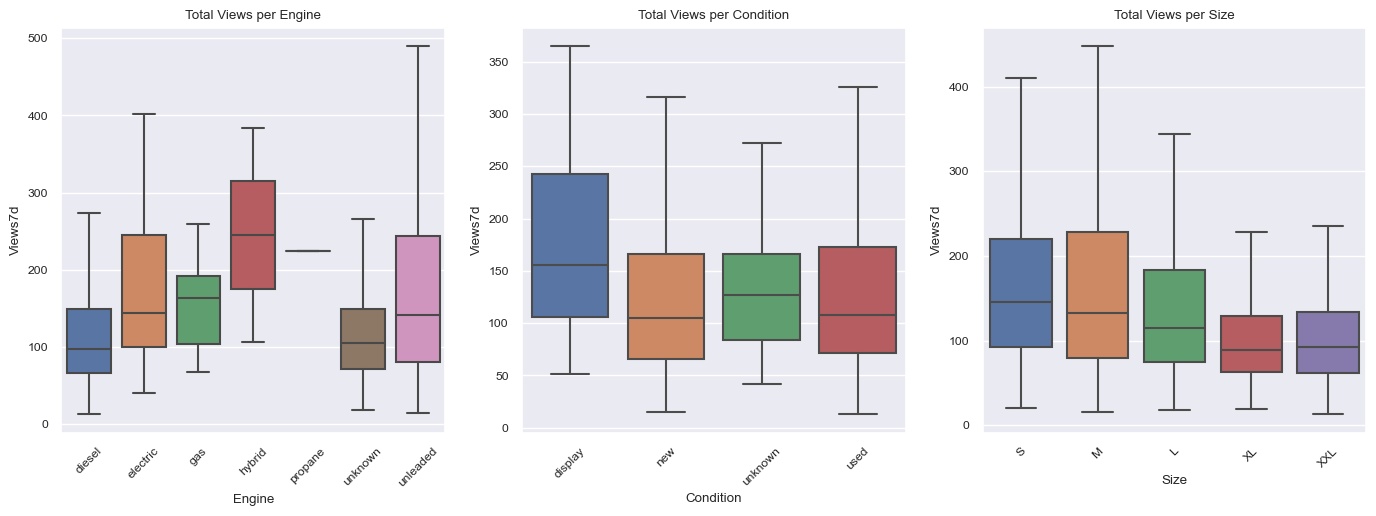

In [139]:
# Boxplots for categorical variables
# Hybrid engines have most views
# Display models have more views
# Smaller boats have more views
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.boxplot(data=df, x='Engine',y=('Views7d'),ax=axes[0], showfliers=False).set(title='Total Views per Engine')
sns.boxplot(data=df, x='Condition',y='Views7d',ax=axes[1], showfliers=False).set(title='Total Views per Condition')
sns.boxplot(data=df, x='Size',y='Views7d', order=['S','M','L', 'XL', 'XXL'],ax=axes[2], showfliers=False).set(title='Total Views per Size')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45);

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Switzerland'),
  Text(1, 0, 'Germany'),
  Text(2, 0, 'Denmark'),
  Text(3, 0, 'Italy'),
  Text(4, 0, 'France'),
  Text(5, 0, 'Spain'),
  Text(6, 0, 'World'),
  Text(7, 0, 'Netherlands'),
  Text(8, 0, 'Croatia'),
  Text(9, 0, 'Portugal'),
  Text(10, 0, 'United Kingdom')])

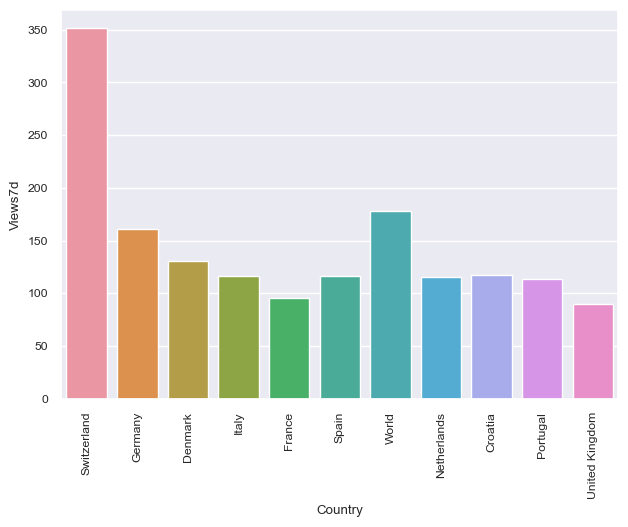

In [140]:
# Views per country, listings from Switserland have generated most views.
fig, axes = plt.subplots()
sns.set(font_scale=0.8)
sns.barplot(data=df, x='Country', y='Views7d',errorbar=None)
plt.xticks(rotation=90)

In [141]:
# A look at the cleaned dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9241 entries, 0 to 9688
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Boat Type     9241 non-null   category
 1   Manufacturer  9241 non-null   object  
 2   Length        9241 non-null   float64 
 3   Width         9241 non-null   float64 
 4   Material      9241 non-null   object  
 5   Location      9241 non-null   object  
 6   Views7d       9241 non-null   int64   
 7   Curr          9241 non-null   object  
 8   Price Eur.    9241 non-null   Float64 
 9   Engine        9241 non-null   category
 10  Condition     9241 non-null   category
 11  Age           9241 non-null   float64 
 12  Size          9241 non-null   category
 13  Country       9241 non-null   object  
dtypes: Float64(1), category(4), float64(3), int64(1), object(5)
memory usage: 1.1+ MB


# Preprocessing
To prepare our data for processing in the machine learning models, a few steps are taken;

- drop features: Location (use Country), Lenght, Width (use Size), Manufacturer
- encode Dummies categorical features: Boat Type, Material, Location, Curr, Engine, Condition, Size, Country
- separate target and explanatory variables
- create scaler on training data and use to scale explanatory variables


In [142]:
# dropping columns
df.drop(columns=['Length', 'Width', 'Location','Manufacturer'], inplace=True)

In [143]:
# Create df dummies for: Boat Type, Material, Curr, Engine, Condition, Size, Country
dummies = pd.get_dummies(df[['Boat Type', 'Material', 'Curr', 'Engine', 'Condition', 'Size', 'Country']], drop_first=True)

# Drop dummies from original df. 
df.drop(columns=['Boat Type', 'Material', 'Curr', 'Engine', 'Condition', 'Size', 'Country'], inplace=True)

# concat df and dummies to create complete df.
df = pd.concat([df,dummies] ,axis=1)

In [144]:
# create explanatory values by dropping location and target feature
X = df.drop(columns=['Views7d'])

# create target value array
y = df['Views7d'].array

In [145]:
# Split data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=777)

In [146]:
print('X train shape: {} | y shape: {}'.format(X_train.shape, y_train.shape))
print('X test shape: {} | y shape: {}'.format(X_test.shape, y_test.shape))

X train shape: (6930, 48) | y shape: (6930,)
X test shape: (2311, 48) | y shape: (2311,)


In [147]:
# Instantiate scaler en fit on train set
scaler = PowerTransformer().fit(X_train)

# Scale both train and test set
std_X_train = scaler.transform(X_train)
std_X_test = scaler.transform(X_test)

# Model Fitting
We are in the Supervised learning domain since we are asked to predict the named variable Views in the last 7 days. Since the target variable is continous we are dealing with a regression problem. 

To work from an easy baseline model I choose to start with a Linear Regression model. Given that we did not see strong linear relations and deal with many outliers, I choose to work with Tree based models for comparison.

### Metrics
- To compare how well the models fit the data and to eachother, I will use R Squared (R2) where a larger number means a better fit.
- To evaluate the model predictions versus the actual views, I will use Mean Absolute Error (MAE / L1 error) since this will give us an easy to interpret number directly in the desired unit of measurement (expected views). The smaller the MAE the less views our prediction is off from the actual views. 


In [148]:
# Try linearRegression as a baseline model 
lr = LinearRegression()

# Fit model on training set
lr.fit(std_X_train, y_train)

# Predict on test set
lr_y_pred = lr.predict(std_X_test)

# R_squared
lr_r_squared = lr.score(std_X_test, y_test)
print('Linear Regression R-squared: {:.2f}'.format(lr_r_squared))

#MAE
lr_mae = mean_absolute_error(y_test, lr_y_pred)
print('Linear Regression MAE: {:.2f}'.format(lr_mae))

Linear Regression R-squared: 0.34
Linear Regression MAE: 70.84


In [149]:
# Instantiate Regression Tree model with guessed hyperparameters
tree = DecisionTreeRegressor(criterion = 'squared_error', max_depth=12,min_samples_leaf=2,random_state=777)

# Fit model on training set
tree.fit(std_X_train,y_train)

# Predict on test set
tree_y_pred = tree.predict(std_X_test)

# R_squared
tree_r_squared = tree.score(std_X_test, y_test)
print("Decision Tree Regressor R-squared: {:.2f}".format(tree_r_squared))

#MAE
tree_mae = mean_absolute_error(y_test, tree_y_pred)
print('Tree Regression MAE: {:.2f}'.format(tree_mae))

Decision Tree Regressor R-squared: 0.18
Tree Regression MAE: 72.26


Our baseline Linear Regression model (r2=0.34) outperformed the single Decision Tree model (r2=0.18). 
To see if a tree based approach could outperform our baseline model, I have created a Random Forest model with 100 Trees. 

In [150]:
# criterion 'absolute error' is significantly slower but produces best result. 
forest = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=777)
forest.fit(std_X_train, y_train)
forest_y_pred = forest.predict(std_X_test)
forest_r2 = forest.score(std_X_test, y_test)
forest_mae = mean_absolute_error(y_test, forest_y_pred)
print("Forest Regressor R-squared: {:.2f}".format(forest_r2))
print('Forest Regressor MAE: {:.2f}'.format(forest_mae))

Forest Regressor R-squared: 0.32
Forest Regressor MAE: 68.35


The Random Forest with 100 Trees performed much better than the single tree but is still outperformed by our baseline Linear Regression model when looking at the r2 socre. 

To minimize the chance that the way our data was split has impacted our scores we run 10 fold crossvalidation and take te mean of our outcomes. 

In [151]:
# 10 fold CV

lr_cv = cross_validate(lr, std_X_train, y_train, cv=10, scoring=['r2','neg_mean_absolute_error'])
tree_cv = cross_validate(tree, std_X_train, y_train, cv=10, scoring=['r2','neg_mean_absolute_error'])
forest_cv = cross_validate(forest, std_X_train, y_train, cv=10, scoring=['r2','neg_mean_absolute_error'])

lr_cv_r_squared = lr_cv['test_r2'].mean()
lr_cv_mae = -1*(lr_cv['test_neg_mean_absolute_error'].mean())
print('Cross Validated Linear Regression R-squared: {:.2f}'.format(lr_cv_r_squared))
print('Cross Validated Linear Regression MAE: {:.2f}'.format(lr_cv_mae))
print("")

tree_cv_r_squared = tree_cv['test_r2'].mean()
tree_cv_mae = -1*(tree_cv['test_neg_mean_absolute_error'].mean())
print("Cross Validated Decision Tree Regressor R-squared: {:.2f}".format(tree_cv_r_squared))
print('Cross Validated Tree Regression MAE: {:.2f}'.format(tree_cv_mae))
print("")

forest_cv_r_squared = forest_cv['test_r2'].mean()
forest_cv_mae = -1*(forest_cv['test_neg_mean_absolute_error'].mean())
print("Cross Validated Random Forest Regressor R-squared: {:.2f}".format(forest_cv_r_squared))
print('Cross Validated Random Forest Regressor MAE: {:.2f}'.format(forest_cv_mae))


Cross Validated Linear Regression R-squared: 0.33
Cross Validated Linear Regression MAE: 70.08

Cross Validated Decision Tree Regressor R-squared: 0.08
Cross Validated Tree Regression MAE: 74.35

Cross Validated Random Forest Regressor R-squared: 0.30
Cross Validated Random Forest Regressor MAE: 67.72


Cross validation showed a bit of difference, especially for the single Desicion Tree model. Since our baseline model is outperforming our Random Forest model, we should tune the hyperparameters of our Random Forest and look for improvement.

We are testing different combinations of hyperparameters and run 4 fold crossvalidation. Note that this might take a minute and adding more folds adds to the processing time. 

In [152]:
# Define grid of hyperparams to tune

params_forest = {
     'max_depth':[6,12,18,24],
     'min_samples_leaf':[0.00005, 0.0001, 0.0005, 0.001],
     'max_features':[0.1,0.3,0.6,0.9]}

In [153]:
# Instantiate 4 fold CV grid search object (more fold increase processing time)

grid_forest = GridSearchCV(estimator=forest,
                          param_grid=params_forest,
                          scoring='r2',
                          cv = 4)

# Fit the grid on training set
grid_forest.fit(std_X_train, y_train)

# Predict
grid_y_pred = grid_forest.predict(std_X_test)

# Extract best hyper parameters
best_grid_hyperparams = grid_forest.best_params_
print("Best Hyperparameters:", best_grid_hyperparams)

# Extract best scores
grid_r2 = grid_forest.score(std_X_test, y_test)
grid_mae = mean_absolute_error(y_test, grid_y_pred)
print("Grid Forest Regressor R-squared: {:.3f}".format(grid_r2))
print('Grid Forest Regressor MAE: {}'.format(grid_mae))

Best Hyperparameters: {'max_depth': 18, 'max_features': 0.3, 'min_samples_leaf': 0.0005}
Grid Forest Regressor R-squared: 0.404
Grid Forest Regressor MAE: 64.04524931085514


Our tuned Random Forest now outperformes the Linear Regression model with the best R2 score we have seen so far: 0.40.

Although we created dummies in our dataframe for the Linear Regression model, we can still visualise feature importance as used in our tuned Random Forest. We can see that different features are among the top predictors, especially: Country_Switserland, Price, Age, Currency. 

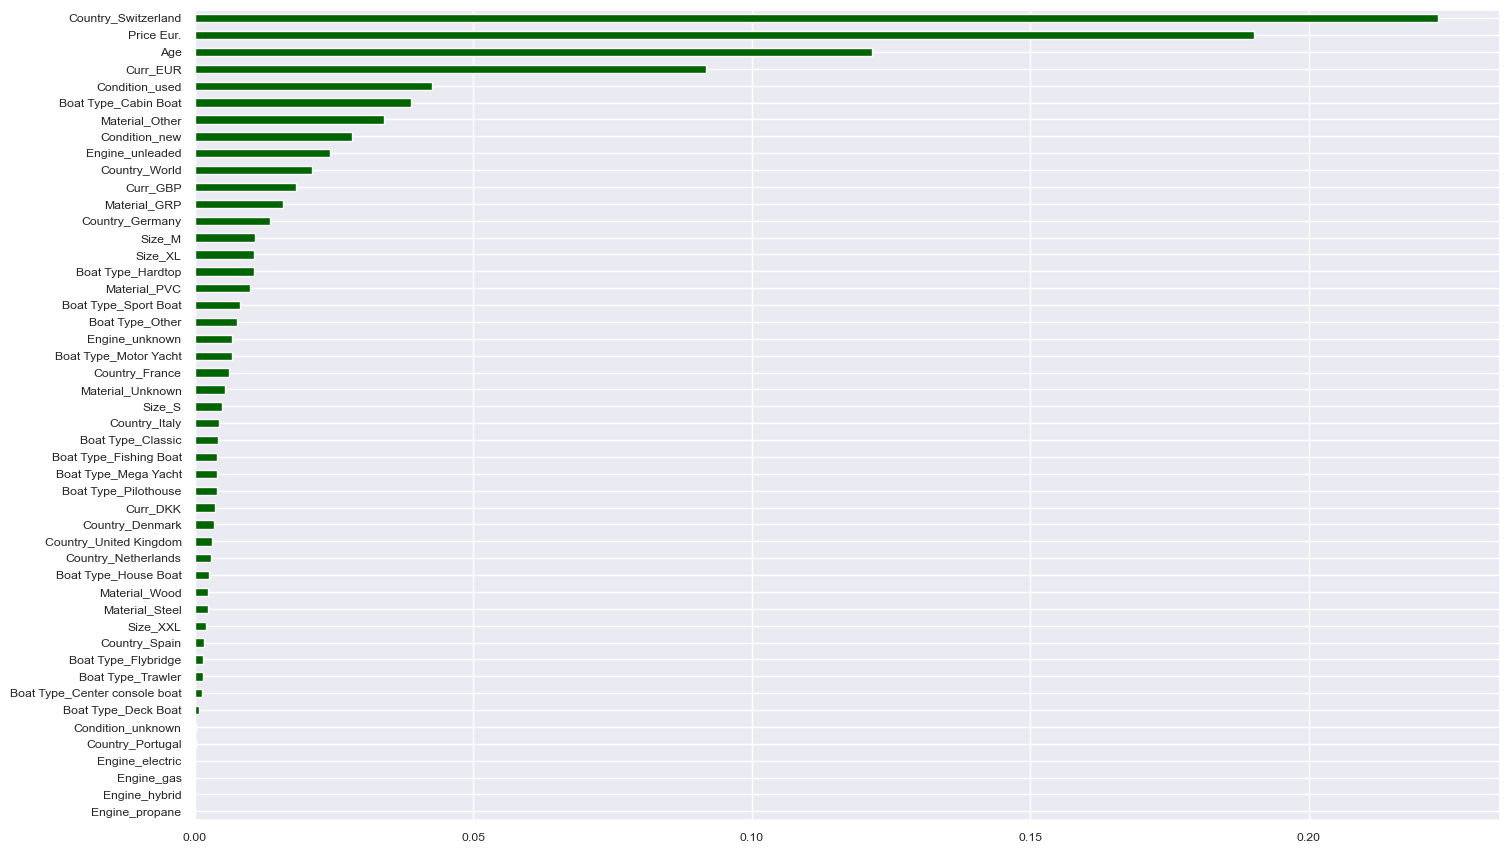

In [154]:
# Create a pd series of feature importances
importances_grid = pd.Series(grid_forest.best_estimator_.feature_importances_, index=X.columns)

# Sort importances
sorted_importances_grid = importances_grid.sort_values()
#sorted_importances_grid_top = sorted_importances_grid.head(10)


# Make horizontal barplot
fig, ax = plt.subplots(figsize=(15,10))
sorted_importances_grid.plot(ax=ax, kind='barh', color='darkgreen', figsize=(15,10))
plt.show()

### Model comparison
We see that tuning our Random Forest hyperparameters has improved our model. The 0,40 R-Squared score is an improvement to our baseline Linear Regression model with an R-Squared of 0,32. This means the tuned Random Forest is the best fit for the data and our explanatory features now explain appr. 40% of the variance in the Views last 7 days.


# Business Metrics - KPI to compare model to business criteria.
The product manager would consider using the model if, on average, the predictions were only 50% off of the true number of views a listing would receive. Our KPI is the relative deviation in predicted views vs actual views.

Since we have the Mean Absolute Error that directly tells us how many views we are off from the true number, we can easily check how far we are off in relative terms. We can check this per model.

In [155]:
# Checking how far off the predictions are on average and comparing on the 50% target given by the Product Manager.

actuals = y_test.mean()
lr_success = (1 - ((actuals - lr_mae) / actuals))*100
tree_success = (1 - ((actuals - tree_mae) / actuals))*100
forest_success = (1 - ((actuals - forest_mae) / actuals))*100
grid_success = (1 - ((actuals - grid_mae) / actuals))*100

models = {'Linear Reg.':lr_success,
          'Decision Tree Reg.':tree_success,
          'Random Forest reg.': forest_success,
         'Gridsearched Forest reg.': grid_success}

def go(x):
    if (x > 50):
        go = " failed! The model should not be considered"
    elif (x<= 50):
        go = " successful! The model should be considered"
    return go

for k, v in models.items():
    print(k + go(v) + " as it's predictions are off by {:.2f}%".format(v))

Linear Reg. successful! The model should be considered as it's predictions are off by 46.82%
Decision Tree Reg. successful! The model should be considered as it's predictions are off by 47.76%
Random Forest reg. successful! The model should be considered as it's predictions are off by 45.17%
Gridsearched Forest reg. successful! The model should be considered as it's predictions are off by 42.33%


In [156]:
# Sanity check, actuals is close to original Views7d mean and our predicted average is withing 50% of the actuals. 

print(actuals)
print(actuals - grid_mae)


151.30073561228906
87.25548630143392


In [157]:
# Metrics overview df
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Tuned Random Forest'],
    'R Squared':[lr_r_squared, tree_r_squared, forest_r2, grid_r2],
    'MAE':[lr_mae, tree_mae, forest_mae, grid_mae],
    'AVG Percent Views off (%)':[lr_success, tree_success, forest_success, grid_success]})

results['MAE'] = round(results['MAE'])
results['AVG Percent Views off (%)'] = round(results['AVG Percent Views off (%)'])
results['Variance Explained %'] = round(results['R Squared']*100)
results.round(2)

,Model,R Squared,MAE,AVG Percent Views off (%),Variance Explained %
0,Linear Regression,0.34,71.0,47.0,34.0
1,Decision Tree,0.18,72.0,48.0,18.0
2,Random Forest,0.32,68.0,45.0,32.0
3,Tuned Random Forest,0.40,64.0,42.0,40.0


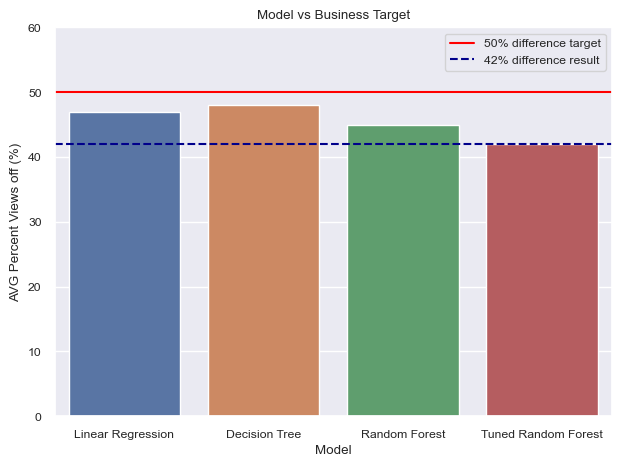

In [158]:
fig, axes = plt.subplots()
sns.barplot(x='Model', y='AVG Percent Views off (%)', data=results)
plt.ylabel('AVG Percent Views off (%)')
plt.ylim(0,60)
plt.axhline(50, color='red', label='50% difference target')
#plt.axhline(47, color='red', label='Baseline Model', linestyle=':')
plt.axhline(42, color='darkblue', label='42% difference result', linestyle='dashed')
plt.title('Model vs Business Target')
plt.legend()

### Success!
As we can see, all models could be considered by the product manager but it is the Grid Searched Random Forest that stands out as the best model while a single Decision Tree gives the worst predictions.

### This project in relation to the business goals
The business looks to attract more potential customers to the website as the end goal. It is stated that boat listings that generate most views generate more traffic and therefore bring in more potential customers and listings with few views should be prevented. Although this statement seems plausible, it is important to emphasize that this causation was no part of this project. In this project we focused on predicting views only. As an example, if very cheap Boat type generates a lot of views we might actually prefer less views on a more expensive Boat Type to improve revenue. 

Also, this project did not incorporate daydates and therefore does not account for date based information such as seasonality. Conclusions in relation to the businessgoals should be made with care as not to discard listings that are sold on their first view based on their lack of views.

### How this work addressed the business problem
This project provides a model that can be implement to predict the number of views within a 50% margin of error as requested by the Product Manager. This model could be implementent in several ways to help the business:
- implementation to prevent listings that will not generate an interesting amount of views to be created at all -> error message to user. 
- implementation that requests the user to update their listing at creation to create a more appealing listing -> alert to user.
- implementation that notifies our Customer Success team to aid our user in creating a better listing -> alert to CS team. 
- implementation that provides input to our marketing team to create campaigns around popular listings or boost traffic for listings that are predicted to stay behind in views. 

### Recommendation for future action
Recommendations regarding the model in this work include:
- Tree based models tend to suffer from large dimensionalities. Since we did not perform dimensionality reduction such as PCA or Feature selection, there is improvement to make. 
- We could use Boosting methods such as AdaBoost or Gradient Boosting to improve our models.
- Further tuning of hyper parameters. We saw that tuning just a few hyperparameters caused grid searched random forest to outperform the other models. Further tuning could improve our predictions.
- Continous gathering of data over time to provide more date to our model more data to learn from and further improve r-squared.

I would also recommend improving the data collection to further improve model performance, for example; 
- The raw data came with many missing values, we could enforce better data colletion by making fields mandatory for users.
- The data did not include the dates of the listings. It would be advisable to add listing date stamps to the date to incorporate views over time metrics and check if seasonality impacts our predicted views per listing.
- Other interesting data points might impact the number of views such as; list id, browsing device, user geo location, (un)registered users, etc.

### Recommendation for implementation
I recommend implementing the tuned Random Forest model in two steps. I recommend step 2 to be taken after the recommendations for future work are executed and the model performance is reevaluated.
- 1. Soft launch: internal notifications to Customer Success and Marketing teams to take action based on predictions. This generates direct value from the work while giving the opportunity to gather qualitative feedback, for instance on user expercience.
- 2. A/B tested launch: once the soft launch has given enough positive feedback, the additional work was exectuted and our model performance is succesful, we can implement the model with A/B testing. In this A/B test we should force part of our users that create bad listings, to edit their listings to larger predicted view numbers. We should then evaluate the forced updated listings, to the listings with bad view predictions. If the forced updated listings are generating more views we could go for full implementation.